# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
# seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56



# Data preparation

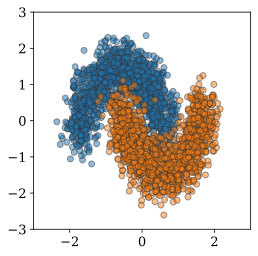

In [17]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'late_rob_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed)


In [18]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-1.8326, -1.0900],
        [ 0.8021, -0.9170],
        [-0.4203, -0.1066],
        [-1.3381,  0.4295],
        [-0.9771,  1.4345],
        [ 0.6912,  0.7894],
        [-2.0056,  0.3858],
        [-0.2490,  1.6288],
        [-0.7548,  1.4363],
        [-0.6259, -0.3925]]) tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 1])


## Model dynamics

In [19]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 15, 15 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [20]:

num_epochs = 60 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [21]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0) 
trainer_anode.train(dataloader, num_epochs)

0.0

Iteration 0/45
Loss: 0.374
Robust Term Loss: 0.000
Accuracy: 0.859

Iteration 10/45
Loss: 0.308
Robust Term Loss: 0.000
Accuracy: 0.906

Iteration 20/45
Loss: 0.383
Robust Term Loss: 0.000
Accuracy: 0.859

Iteration 30/45
Loss: 0.317
Robust Term Loss: 0.000
Accuracy: 0.891

Iteration 40/45
Loss: 0.332
Robust Term Loss: 0.000
Accuracy: 0.891
Epoch 1: 0.382
0.0

Iteration 0/45
Loss: 0.245
Robust Term Loss: 0.000
Accuracy: 0.938

Iteration 10/45
Loss: 0.388
Robust Term Loss: 0.000
Accuracy: 0.859

Iteration 20/45
Loss: 0.180
Robust Term Loss: 0.000
Accuracy: 0.969

Iteration 30/45
Loss: 0.376
Robust Term Loss: 0.000
Accuracy: 0.875

Iteration 40/45
Loss: 0.320
Robust Term Loss: 0.000
Accuracy: 0.906
Epoch 2: 0.319
0.0

Iteration 0/45
Loss: 0.339
Robust Term Loss: 0.000
Accuracy: 0.891

Iteration 10/45
Loss: 0.295
Robust Term Loss: 0.000
Accuracy: 0.922

Iteration 20/45
Loss: 0.154
Robust Term Loss: 0.000
Accuracy: 0.953

Iteration 30/45
Loss: 0.345
Robust Term Loss: 0.000
Accuracy: 0

In [22]:
   
w = anode.linear_layer.weight
b = anode.linear_layer.bias

print(w)
print(b)

rnode.linear_layer.weight = w
rnode.linear_layer.bias = b

rnode.linear_layer.requires_grad =  False

Parameter containing:
tensor([[-0.4991, -0.1321],
        [ 0.4187, -0.9095]], requires_grad=True)
Parameter containing:
tensor([-0.6633,  0.2502], requires_grad=True)


In [23]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps) 
trainer_rnode.train(dataloader, num_epochs)

0.2

Iteration 0/45
Loss: 0.415
Robust Term Loss: 0.134
Accuracy: 0.891

Iteration 10/45
Loss: 0.328
Robust Term Loss: 0.146
Accuracy: 0.922

Iteration 20/45
Loss: 0.394
Robust Term Loss: 0.142
Accuracy: 0.891

Iteration 30/45
Loss: 0.685
Robust Term Loss: 0.255
Accuracy: 0.781

Iteration 40/45
Loss: 0.465
Robust Term Loss: 0.165
Accuracy: 0.891
Epoch 1: 0.496
0.2

Iteration 0/45
Loss: 0.517
Robust Term Loss: 0.180
Accuracy: 0.844

Iteration 10/45
Loss: 0.447
Robust Term Loss: 0.178
Accuracy: 0.844

Iteration 20/45
Loss: 0.387
Robust Term Loss: 0.138
Accuracy: 0.906

Iteration 30/45
Loss: 0.442
Robust Term Loss: 0.162
Accuracy: 0.812

Iteration 40/45
Loss: 0.282
Robust Term Loss: 0.101
Accuracy: 0.922
Epoch 2: 0.390
0.2

Iteration 0/45
Loss: 0.323
Robust Term Loss: 0.126
Accuracy: 0.891

Iteration 10/45
Loss: 0.453
Robust Term Loss: 0.146
Accuracy: 0.844

Iteration 20/45
Loss: 0.416
Robust Term Loss: 0.141
Accuracy: 0.859

Iteration 30/45
Loss: 0.360
Robust Term Loss: 0.145
Accuracy: 0

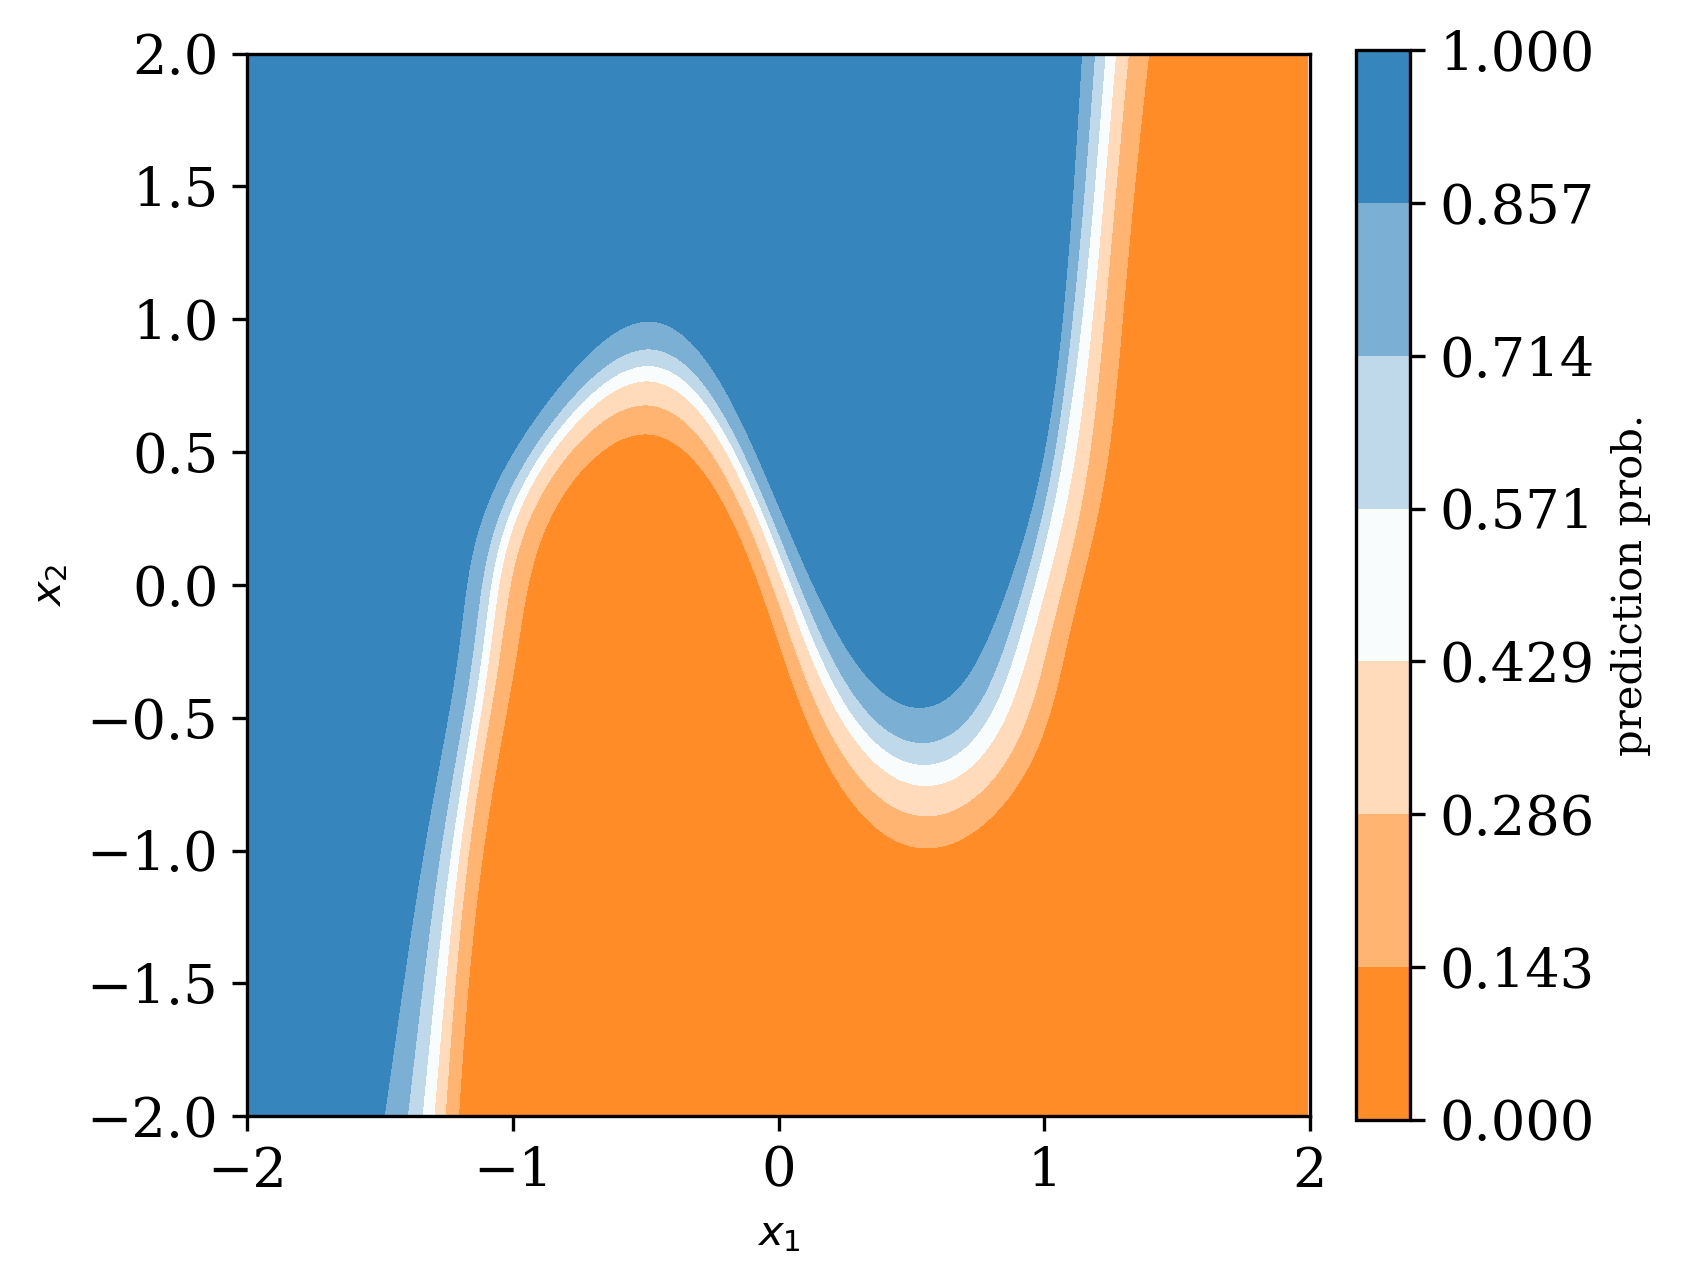

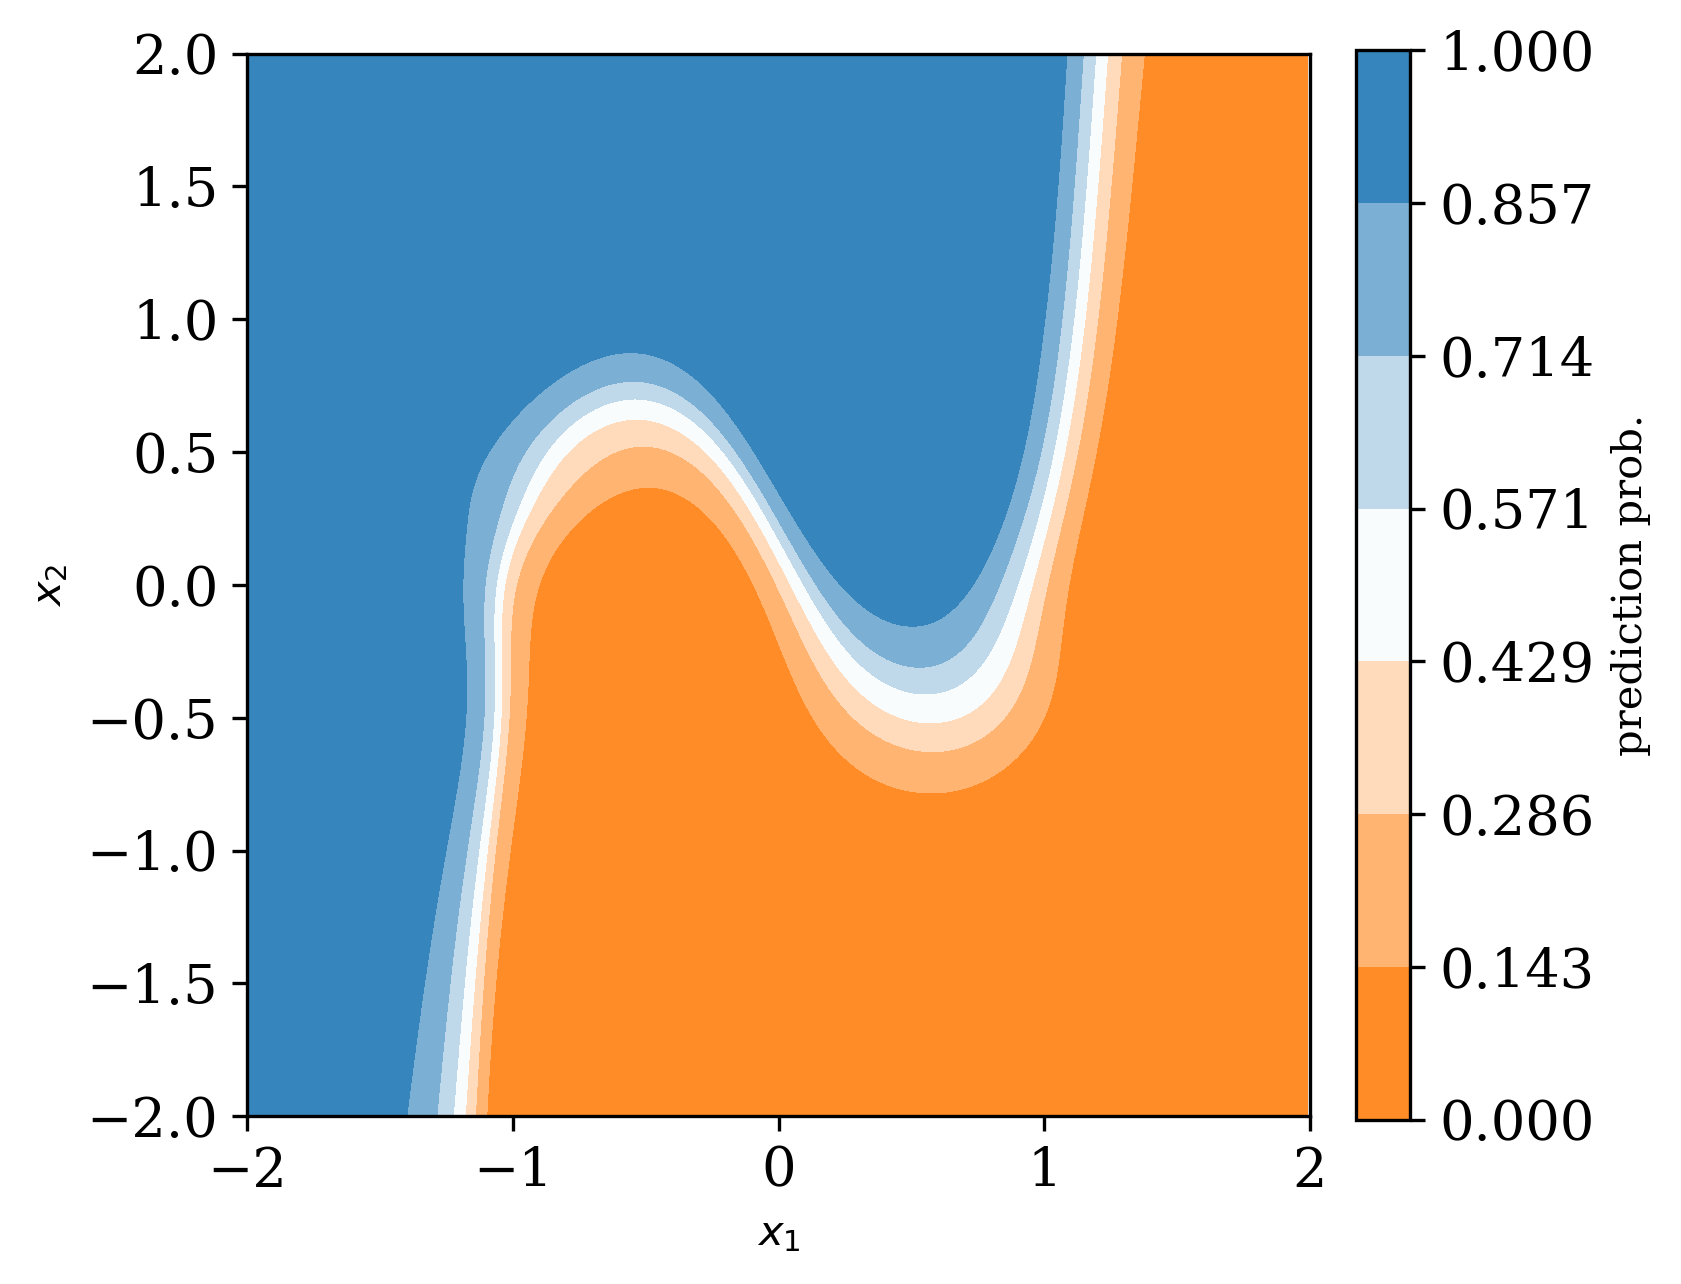

In [24]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base)
classification_levelsets(rnode, fig_name_base + '_rob')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)

display(img1,img2)

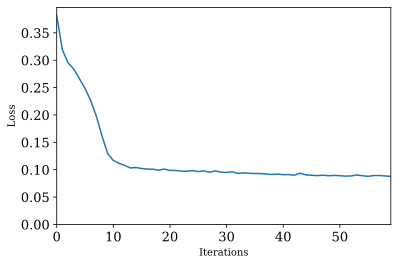

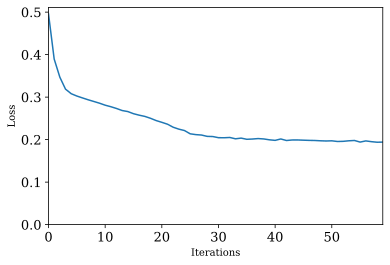

In [25]:
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

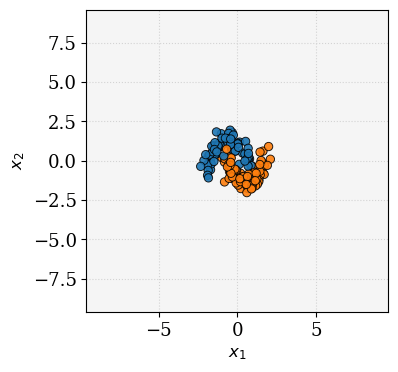

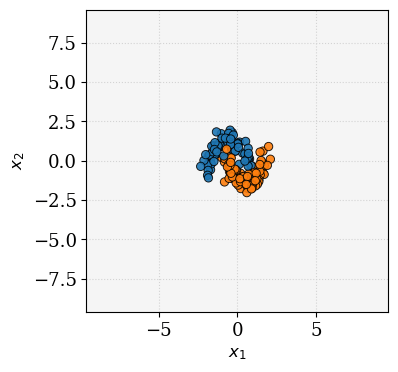

In [26]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif", retina = True)
rtraj = Image(filename="trajectory_db.gif", retina = True)
display(traj, rtraj)

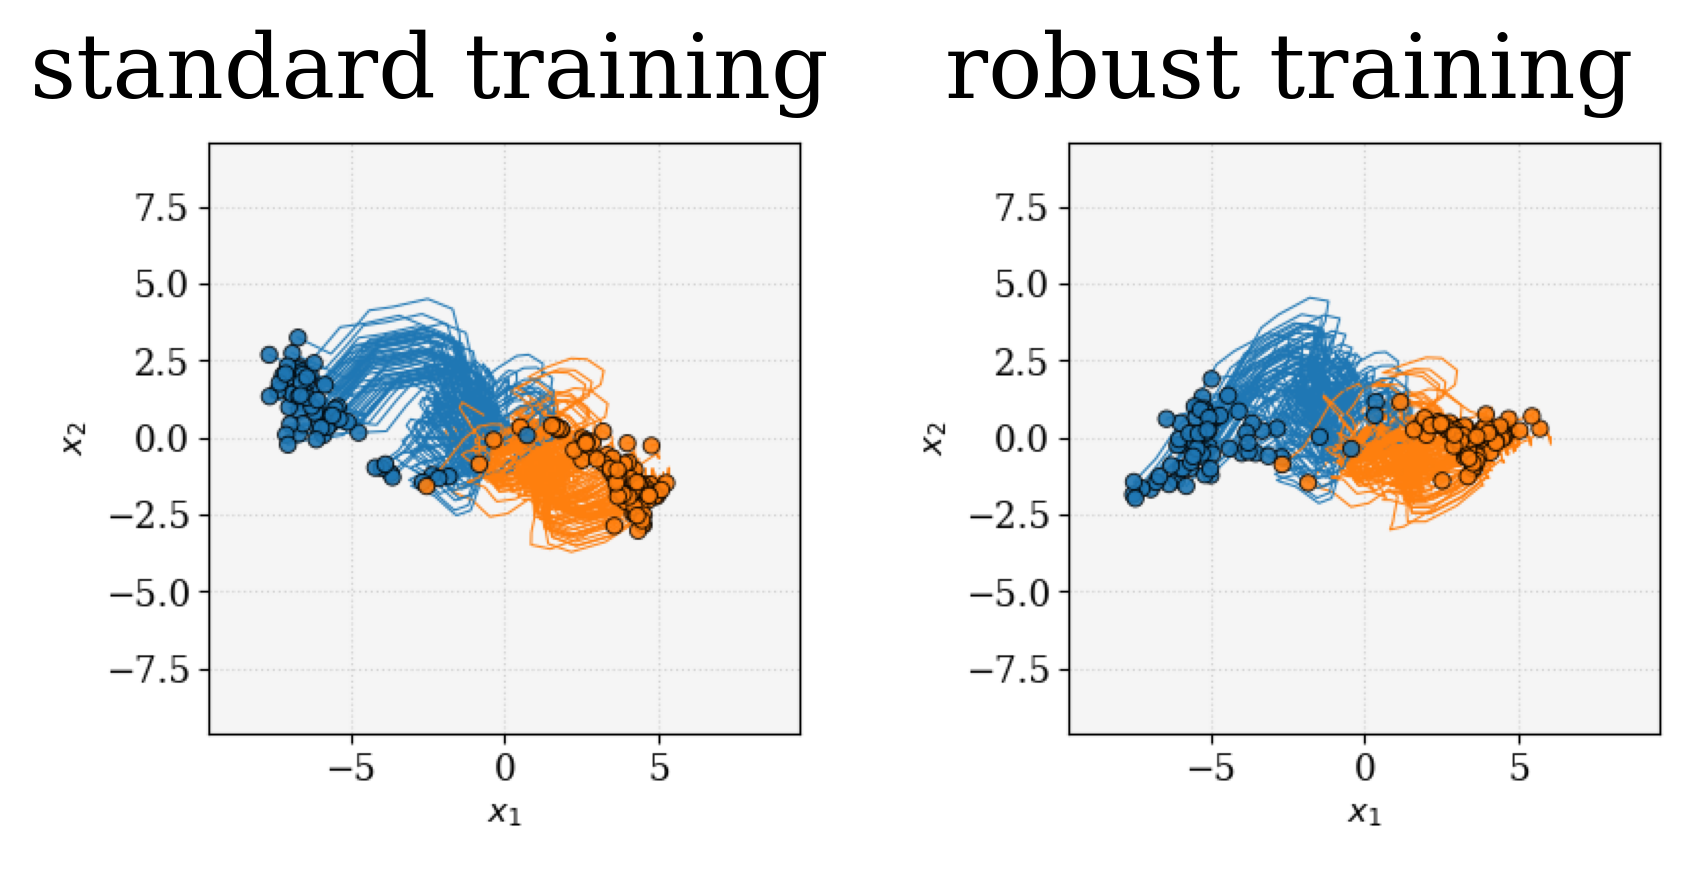

In [28]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))